# Homework - Bayesian modeling - Part B (40 points) 
## Probabilistic programs for productive reasoning

by *Brenden Lake* and *Todd Gureckis*  
Computational Cognitive Modeling  
NYU class webpage: https://brendenlake.github.io/CCM-site/  

People can reason in very flexible and sophisticated ways. Let's consider an example that was introduced in Gerstenberg and Goodman (2012; see below for reference). Imagine that Brenden and Todd are playing tennis together, and Brenden wins the game. You might suspect that Brenden is a strong player, but you may also not think much of it, since it was only one game and we don't know much about Todd's ability.

Now imagine that you also learn that Todd has recently played against two other faculty members in the Psychology department, and he won both of those games. You would now have a higher opinion of Brenden's skill.

Now, say you also learn that Todd was feeling very lazy in his game against Brenden. This could change your opinion yet again about Brenden's skill.

In this notebook, you will get hands on experience using simple probabilistic programs and Bayesian inference to model these patterns of reasoning. Probabilistic programs are a powerful way to write Bayesian models, and they are especially useful when the prior distribution is more complex than a list of hypotheses, or is inconvenient to represent with a probabilistic graphical model.

Probabilistic programming is an active area of research. There are specially designed probabilistic programming languages such as [WebPPL](http://webppl.org/). Other languages have been introduced that combine aspects of probabilistic programming and neural networks, such as [Pyro](http://pyro.ai/), and [Edward](http://edwardlib.org/). Rather than using a particular language, we will use vanilla Python to express an interesting probability distribution as a probabilistic program, and you will be asked to write your own rejection sampler for inference. More generally, an important component of the appeal of probabilistic programming is that when using a specialized language, you can take advantage of general algorithms for Bayesian inference without having to implement your own.

Great, let's proceed with the probabilistic model of tennis!

<div class="alert alert-info">
The Bayesian tennis game was introduced by Tobi Gerstenberg and Noah Goodman in the following material:
<br>
<ul>
    <li>Gerstenberg, T., & Goodman, N. (2012). Ping Pong in Church: Productive use of concepts in human probabilistic inference. In Proceedings of the Annual Meeting of the Cognitive Science Society.</li>
    <li>Probabilistic models of cognition online book (Chapter 3) (https://probmods.org/chapters/03-conditioning.html)</li>
</ul>

</div>

## Probabilistic model

The generative model can be described as follows. There are various players engaged in a tennis tournament. Matches can be played either as a singles match (Player A vs. Player B) or as a doubles match (Player A and Player B vs. Player C and Player D).

Each player has a latent `strength` value which describes his or her skill at tennis. This quantity is unobserved for each player, and it is a persistent property in the world. Therefore, the `strength` stays the same across the entire set of matches.

A match is decided by whichever team has more `team_strength`. Thus, if it's just Player A vs. Player B, the stronger player will win. If it's a doubles match, `team_strength` is the sum of the strengths determines which team will be the `winner`. However, there is an additional complication. On occasion (with probability 0.1), a player becomes `lazy`, in that he or she doesn't try very hard for this particular match. For the purpose of this match, his or her `strength` is reduced by half. Importantly, this is a temporary (non-persistent) state which is does not affect the next match.

This completes our generative model of how the data is produced. In this assignment, we will use Bayesian inference to reason about latent parameters in the model, such as reasoning about a player's strength given observations of his or her performance.

### Concepts as programs
**A powerful idea is that we can model concepts like `strength`, `lazy`, `team_strength`, `winner`, and `beat` as programs, usually simple stochastic functions that operate on inputs and produce outputs.** You will see many examples of this in the code below. Under this view, the meaning of a "word" comes from the semantics of the program, and how the program interact with eachother. Can all of our everyday concepts be represented as programs? It's an open question, and the excitement around probabilistic programming is that it provides a toolkit for exploring this idea.

In [23]:
# Import the necessary packages
from __future__ import print_function
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import random
import numpy as np
from scipy.stats.mstats import pearsonr

### Persistent properties
The strength of each player is the only persistent property. In the code below, we create a `world` class which stores the persistent states. In this case, it's simply a dictionary `dict_strength` that maps each player's name to his or her strength. Conveniently, the world class gives us a method `clear` that resets the world state, which is useful when we want to clear everything and produce a fresh sample of the world.

The `strength` function takes a player's `name` and queries the world `W` for the appropriate strength value. If it's a new player, their strength is sampled from a Gaussian distribution (with $\mu=10$ and $\sigma=3$) and stored persistently in the world state. As you can see, this captures something about our intuitive notion of strength as a persistent property.



In [24]:
class world():
    def __init__(self):
        self.dict_strength = {}
    def clear(self): # used when sampling over possible world
        self.dict_strength = {}

W = world()

def strength(name):
    if name not in W.dict_strength:
        W.dict_strength[name] = abs(random.gauss(10,3))
    return W.dict_strength[name]

### Computing team strength
Next is the `lazy` function. When the lazy function is called on the `name` of a particular player, the answer is computed fresh each time (and is not stored persistently like strength).

The total strength of a team `team_strength` takes a list of names `team` and computes the aggregate strength. This is a simple sum across the team members, with a special case for lazy team members. For a game like tennis, this program captures aspects of what we mean when we think about "the strength of a team" -- although simplified, of course.

In [25]:
def lazy(name):
    return random.random() < 0.1

In [26]:
def team_strength(team):
    # team : list of names
    mysum = 0.
    for name in team:
        if lazy(name):
            mysum += (strength(name) / 2.)
        else:
            mysum += strength(name)
    return mysum

### Computing the winner
The `winner` of a match returns the team with a higher strength value. Again, we can represent this as a very simple function of `team_strength`.

Finally, the function `beat` checks whether `team1` outperformed `team2` (returning `True`) or not (returning `False`).

In [27]:
def winner(team1,team2):
    # team1 : list of names
    # team2 : list of names
    if team_strength(team1) > team_strength(team2):
        return team1
    else:
        return team2

def beat(team1,team2):
    return winner(team1,team2) == team1

# Probabilistic inference
<div class="alert alert-success" role="alert">
<h3> Problem 1 (15 points) </h3>
<br>
Your first task is to complete the missing code in the `rejection_sampler` function below to perform probabilistic inference in the model. You give it a list of function handles `list_f_conditions` which represent the data we are conditioning on, and thus these functions must evaluate to `True` in the current state of the world. If they do, then you want to grab the variable of interest using the function handle `f_return` and store it in the `samples` vector, which is returned as a numpy array.

Please fill out the function below.
</div>

<div class="alert alert-info">
Note: A function handle `f_return` is a pointer to a function which can be executed with the syntax `f_return()`. We need to pass handles, rather than pre-executed functions, so the rejection sampler can control for itself when to execute the functions.
</div>

In [28]:
def rejection_sampler(f_return, list_f_conditions, nsamp=10000):
    # Input
    #  f_return : function handle that grabs the variable of interest when executed
    #  list_f_conditions: list of conditions (function handles) that we are assuming are True
    #  nsamp : number of attempted samples (default is 10000)
    # Output
    #  samples : (as a numpy-array) where length is the number of actual, accepted samples
    list=['bob', 'mary','tom', 'sue']
    samples = []
    for i in range(nsamp):
        W.clear()
        if all(f() for f in list_f_conditions):
            sample = f_return()
            samples.append(sample)

    return np.array(samples)

Use the code below to test your rejection sampler. Let's assume Bob and Mary beat Tom and Sue in their tennis match. Also, Bob and Sue beat Tom and Jim. What is our mean estimate of Bob's strength? (The right answer is around 11.86, but you won't get that exactly. Check that you are in the same ballpark). 

In [29]:
f_return = lambda : strength('bob')
list_f_conditions = [lambda : beat( ['bob', 'mary'],['tom', 'sue'] ), lambda : beat( ['bob', 'sue'],  ['tom', 'jim'] )]
samples = rejection_sampler(f_return, list_f_conditions, nsamp=50000)
mean_strength = np.mean(samples)
print("Estimate of Bob's strength: mean = " + str(mean_strength) + "; effective n = " + str(len(samples)))

Estimate of Bob's strength: mean = 11.845029964105747; effective n = 14139


## Comparing judgments from people and the model
We want to explore how well the model matches human judgments of strength. In the table below, there are six different doubles tennis tournaments. Each tournament consists of three doubles matches, and each letter represents a different player. Thus, in the first tournament, the first match shows Player A and Player B winning against Player C and Player D. In the second match, Player A and Player B win against Player E and F. Given the evidence, how strong is Player A in Scenario 1? How strong is Player A in Scenario 2? The data in the different scenarios should be considered separate (they are alternative possible worlds, rather than sequential tournaments).

<div class="alert alert-success" role="alert">
For each tournament, rate how strong you think Player A is using a 1 to 7 scale, where 1 is the weakest and 7 is the strongest. Also, explain the scenario to a friend and ask for their ratings as well. Be sure to mention that sometimes a player is lazy (about 10 percent of the time) and doesn't perform as well. 
</div>

<img src="images/tennis_games.jpeg" style="width: 600px;"/>

In [30]:
# TODO : YOUR DATA GOES HERE

subject2_pred = np.array([4,4,5,2,7,7])
subject1_pred = np.array([3,3,3,4,6,6])

The code below will use your rejection sampler to predict the strength of Player A in all six of the scenarios. These six numbers will be stored in the array `model_pred`

In [31]:
model_pred = []

f_return = lambda : strength('A')

f_conditions = [lambda : beat( ['A', 'B'],['C', 'D'] ), lambda : beat( ['A', 'B'],['E', 'F'] ), lambda : beat( ['A', 'B'],  ['G', 'H'] ) ]
samples = rejection_sampler(f_return, f_conditions)
print("Scenario 1")
print("  sample mean : " + str(np.mean(samples)) + "; n=" + str(len(samples)))
model_pred.append(np.mean(samples))

f_conditions = [lambda : beat( ['A', 'B'],['E', 'F'] ), lambda : beat( ['A', 'C'],['E', 'G'] ), lambda : beat( ['A', 'D'],  ['E', 'H'] ) ]
samples = rejection_sampler(f_return, f_conditions)
print("Scenario 2")
print("  sample mean : " + str(np.mean(samples)) + "; n=" + str(len(samples)))
model_pred.append(np.mean(samples))

f_conditions = [lambda : beat( ['A', 'B'],['E', 'F'] ), lambda : beat(['E', 'F'], ['B', 'C'] ), lambda : beat( ['E', 'F'], ['B', 'D'] ) ]
samples = rejection_sampler(f_return, f_conditions)
print("Scenario 3")
print("  sample mean : " + str(np.mean(samples)) + "; n=" + str(len(samples)))
model_pred.append(np.mean(samples))

f_conditions = [lambda : beat( ['A', 'B'],['E', 'F'] ), lambda : beat( ['B', 'C'],['E', 'F'] ), lambda : beat( ['B', 'D'],  ['E', 'F'] ) ]
samples = rejection_sampler(f_return, f_conditions)
print("Scenario 4")
print("  sample mean : " + str(np.mean(samples)) + "; n=" + str(len(samples)))
model_pred.append(np.mean(samples))

f_conditions = [lambda : beat( ['A', 'B'],['E', 'F'] ), lambda : beat( ['A', 'C'],['G', 'H'] ), lambda : beat( ['A', 'D'],  ['I', 'J'] ) ]
samples = rejection_sampler(f_return, f_conditions)
print("Scenario 5")
print("  sample mean : " + str(np.mean(samples)) + "; n=" + str(len(samples)))
model_pred.append(np.mean(samples))

f_conditions = [lambda : beat( ['A', 'B'],['C', 'D'] ), lambda : beat( ['A', 'C'],['B', 'D'] ), lambda : beat( ['A', 'D'],  ['B', 'C'] ) ]
samples = rejection_sampler(f_return, f_conditions)
print("Scenario 6")
print("  sample mean : " + str(np.mean(samples)) + "; n=" + str(len(samples)))
model_pred.append(np.mean(samples))

Scenario 1
  sample mean : 12.00072731479913; n=2156
Scenario 2
  sample mean : 12.082420300944914; n=2169
Scenario 3
  sample mean : 11.889800535596923; n=750


Scenario 4
  sample mean : 10.526685103612843; n=2731
Scenario 5
  sample mean : 12.492880430712049; n=1713
Scenario 6
  sample mean : 13.149998216622816; n=1240


This code creates a bar graph to compare the human and model predictions for Player A's strength.

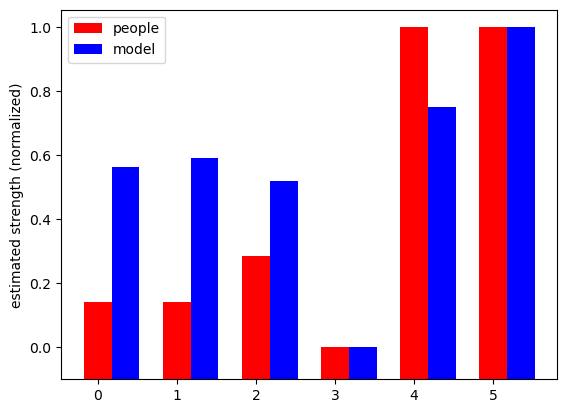

correlation between human and model predictions; r = 0.798


In [32]:
def normalize(v):
    # scale vector v to have min 0 and max 1
    v = v - np.min(v)
    v = v / np.max(v)
    return v

human_pred_norm = normalize((subject1_pred+subject2_pred)/2.)
model_pred_norm = normalize(model_pred)

# compare predictions from people vs. Bayesian mdoel
mybottom = -0.1
width = 0.35 
plt.figure(1)
plt.bar(np.arange(len(human_pred_norm)),human_pred_norm-mybottom, width, bottom=mybottom, color='red')
plt.bar(np.arange(len(human_pred_norm))+width, model_pred_norm-mybottom, width, bottom=mybottom, color='blue')
plt.ylabel('estimated strength (normalized)')
plt.legend(('people','model'))
plt.show()

r = pearsonr(human_pred_norm,model_pred_norm)[0]
print('correlation between human and model predictions; r = ' + str(round(r,3)))


<div class="alert alert-success" role="alert">
<h3> Problem 2 (10 points) </h3>
<br>
In the cell below, briefly comment on whether or not the model is a good account of the human judgments. Which of the six scenarios do you think indicates that Player A is the strongest? Which of the scenarios indicates the Player A is the weakest? Does the model agree? Your reponse should be one or two paragraphs.
</div>

Yes, the model is good account.

The result is similar. The judgment of human and model is basically the same, in the third scenario, A's ability is weakest, and in the last two scenarios, A's ability is strongest. I think this model is A good one because in scenarios 1 and 2 the team A plays is always winning. This shows that the model's judgment of A's ability can be reasonably explained

<div class="alert alert-success" role="alert">
<h3> Problem 3 (15 points) </h3>
<br>
In the last problem, your job is to modify the probabilistic program to make the scenario slightly more complex. We have reimplemented the probabilistic program below with all the functions duplicated with a "_v2" flag.
<br><br>
The idea is that players may also have a "temper," which is a binary variable that is either `True` or `False`. Like `strength`, a player's temper is a PERSISENT variable that should be added to the world state. The probability that any given player has a temper is 0.2. Once a temper is sampled, its value persists until the world is cleared.
<br><br>
How does the temper variable change the model? If ALL the players on a team have a temper, the overall team strength (sum strength) is divided by 4! Otherwise, there is no effect.
<br><br>
Here is the assignment:
<ul>
    <li>First, write complete the function `has_temper` below such that each name is assigned a binary temper value that is persistent like strength. Store this temper value in the world state using `dict_temper.` [Hint: This function will look a lot like the `strength_v2` function]</li>
    <li>Second, modify the `team_strength_v2` function to account for the case that all team members have a temper.</li>
    <li>Third, run the simulation below comparing the case where Tom and Sue both have tempers to the case where Tom and Sue do not have tempers. How does this influence our inference about Bob's strength? Why? Write a one paragraph response in the very last cell explaining your answer.
</ul>
</div>

In [33]:
class world_v2():
    def __init__(self):
        self.dict_strength = {}
        self.dict_temper = {}
    def clear(self): # used when sampling over possible world
        self.dict_strength = {}
        self.dict_temper = {}

def strength_v2(name):
    if name not in W.dict_strength:
        W.dict_strength[name] = abs(random.gauss(10,3))
    return W.dict_strength[name]

def lazy_v2(name):
    return random.random() < 0.1
        
def has_temper(name):
    # each player has a 0.2 probability of having a temper
    # TODO: YOUR CODE GOES HERE
    if name not in W.dict_temper:
        if random.random()<0.2:
            W.dict_temper[name] = 1
        else:
            W.dict_temper[name]=0
    return W.dict_temper[name]
    
    
def team_strength_v2(team):
    # team : list of names
    mysum = 0.
    for name in team:
        if lazy_v2(name):
            mysum += (strength_v2(name) / 2.)
        else:
            mysum += strength_v2(name)
    # if all of the players have a temper, divide sum strength by 4
    ## TODO : YOUR CODE GOES HERE
    tt=1
    for name in team:
        tt*=has_temper(name)
    if tt>0.00001:
       mysum=mysum/4 
    return mysum

def winner_v2(team1,team2):
    # team1 : list of names
    # team2 : list of names
    if team_strength_v2(team1) > team_strength_v2(team2):
        return team1
    else:
        return team2

def beat_v2(team1,team2):
    return winner_v2(team1,team2) == team1

W = world_v2()

f_return = lambda : strength_v2('bob')
list_f_conditions = [lambda : not has_temper('tom'), lambda : not has_temper('sue'), lambda : beat_v2( ['bob', 'mary'],['tom', 'sue'] ), lambda : beat_v2( ['bob', 'sue'],  ['tom', 'jim'] )]
samples = rejection_sampler(f_return, list_f_conditions, nsamp=100000)
mean_strength = np.mean(samples)
print("If Tom and Sue do not have tempers...")
print("  Estimate of Bob's strength: mean = " + str(mean_strength) + "; effective n = " + str(len(samples)))

list_f_conditions = [lambda : has_temper('tom'), lambda : has_temper('sue'), lambda : beat_v2( ['bob', 'mary'],['tom', 'sue'] ), lambda : beat_v2( ['bob', 'sue'],  ['tom', 'jim'] )]
samples = rejection_sampler(f_return, list_f_conditions, nsamp=100000)
mean_strength = np.mean(samples)
print("If Tom and Sue BOTH have tempers...")
print("  Estimate of Bob's strength: mean = " + str(mean_strength) + "; effective n = " + str(len(samples)))

If Tom and Sue do not have tempers...
  Estimate of Bob's strength: mean = 11.833448453643069; effective n = 17241
If Tom and Sue BOTH have tempers...
  Estimate of Bob's strength: mean = 10.765502299819222; effective n = 1973


Yes,if 'tom', 'sue' has Both has temper, the first match tells no new information almost. Hence the result only depends on the second match. 